In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support as score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.utils import compute_sample_weight
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the train data
path = '/content/predictive_maintenance.csv'
df = pd.read_csv(path)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
# define the target
target_name='Failure Type'

In [4]:
# check for missing values
def print_missing_values(df):
    null_df = pd.DataFrame(df.isna().sum(), columns=['null_values']).sort_values(['null_values'], ascending=False)
    fig = plt.subplots(figsize=(16, 6))
    ax = sns.barplot(data=null_df, x='null_values', y=null_df.index, color='royalblue')
    pct_values = [' {:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(null_df['null_values'])]
    ax.set_title('Overview of missing values')
    ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)

if df.isna().sum().sum() > 0:
    print_missing_values(df)
else:
    print('no missing values')

no missing values


In [5]:
# drop all columns with more than 5% missing values
for col_name in df.columns:
    if df[col_name].isna().sum()/df.shape[0] > 0.05:
        df.drop(columns=[col_name], inplace=True)

In [6]:
# drop id columns
df_base = df.drop(columns=['Product ID', 'UDI'])

# adjust column names
df_base.rename(columns={'Air temperature [K]': 'air_temperature',
                        'Process temperature [K]': 'process_temperature',
                        'Rotational speed [rpm]':'rotational_speed',
                        'Torque [Nm]': 'torque',
                        'Tool wear [min]': 'tool_wear'}, inplace=True)
df_base.head()

,Type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


In [7]:
# display class distribution of the target variable
px.histogram(df_base, y="Failure Type", color="Failure Type")

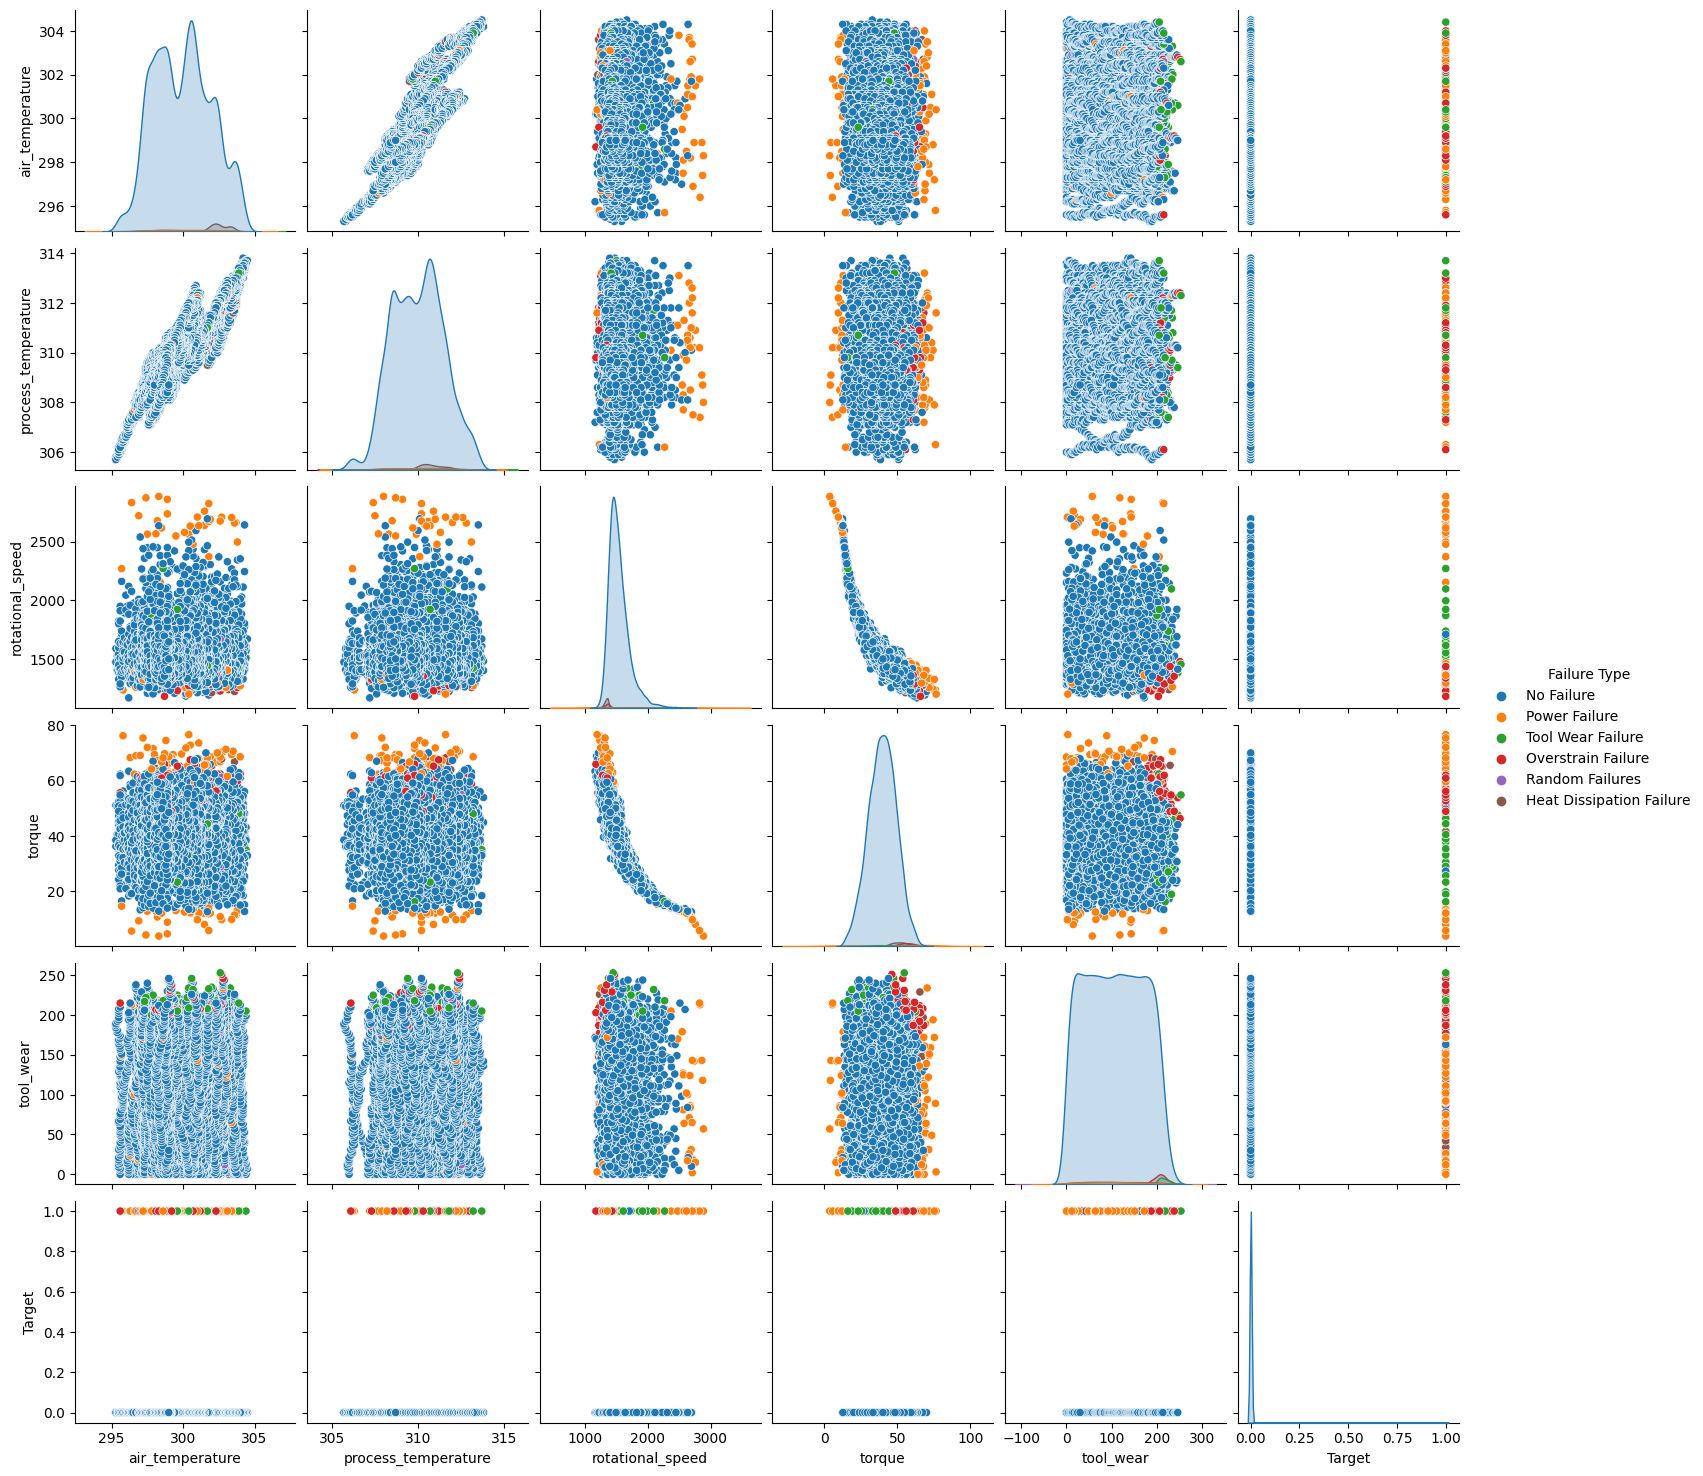

In [8]:
# pairplots on failure type
sns.pairplot(df_base, height=2.5, hue='Failure Type')

<ipython-input-9-e766ef847098>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

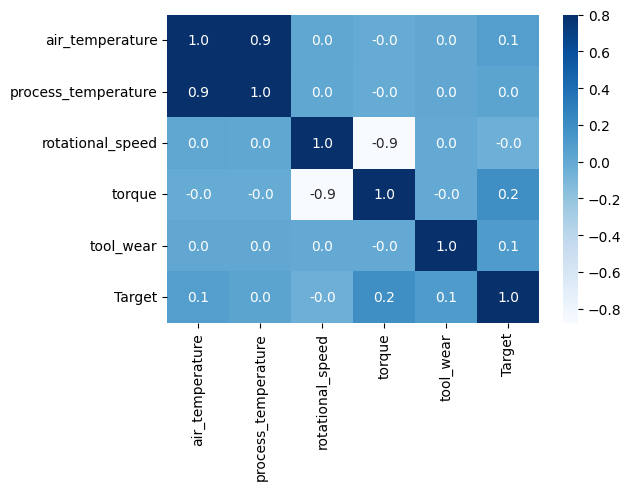

In [9]:
# correlation plot
plt.figure(figsize=(6,4))
sns.heatmap(df_base.corr(), cbar=True, fmt='.1f', vmax=0.8, annot=True, cmap='Blues')

In [10]:
# create histograms for feature columns separated by target column
def create_histogram(column_name):
    plt.figure(figsize=(16,6))
    return px.box(data_frame=df_base, y=column_name, color='Failure Type', points="all", width=1200)

create_histogram('air_temperature')

<Figure size 1600x600 with 0 Axes>

In [11]:
def data_preparation(df_base, target_name):
    df = df_base.dropna()

    df['target_name_encoded'] = df[target_name].replace({'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2, 'Overstrain Failure': 3, 'Random Failures': 4, 'Heat Dissipation Failure': 5})
    df['Type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)
    X = df.drop(columns=[target_name, 'target_name_encoded'])
    y = df['target_name_encoded'] #Prediction label

    # split the data into x_train and y_train data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print('train: ', X_train.shape, y_train.shape)
    print('test: ', X_test.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

# remove target from training data
X, y, X_train, X_test, y_train, y_test = data_preparation(df_base, target_name)

train:  (7000, 7) (7000,)
test:  (3000, 7) (3000,)


In [12]:
weight_train = compute_sample_weight('balanced', y_train)
weight_test = compute_sample_weight('balanced', y_test)

xgb_clf = XGBClassifier(booster='gbtree',
                        tree_method='gpu_hist',
                        sampling_method='gradient_based',
                        eval_metric='aucpr',
                        objective='multi:softmax',
                        num_class=6)
# fit the model to the data
xgb_clf.fit(X_train, y_train.ravel(), sample_weight=weight_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[17:40:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

In [15]:
# score the model with the test dataset
score = xgb_clf.score(X_test, y_test.ravel(), sample_weight=weight_test)

# predict on the test dataset
y_pred = xgb_clf.predict(X_test)

# print a classification report
results_log = classification_report(y_test, y_pred, target_names=['No Failure', 'Power Failure', 'Tool Wear Failure', 'Overstrain Failure', 'Random Failures', 'Heat Dissipation Failure'])
print(results_log)

                          precision    recall  f1-score   support

              No Failure       1.00      1.00      1.00      2903
           Power Failure       0.83      1.00      0.91        24
       Tool Wear Failure       0.91      0.83      0.87        12
      Overstrain Failure       0.92      0.85      0.88        27
         Random Failures       0.00      0.00      0.00         4
Heat Dissipation Failure       0.97      1.00      0.98        30

                accuracy                           1.00      3000
               macro avg       0.77      0.78      0.77      3000
            weighted avg       0.99      1.00      1.00      3000

